In [1]:
import numpy as np

import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.pipeline import Pipeline

from sklearn.linear_model import Ridge, Lasso

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.feature_selection import SelectKBest, f_regression

import ast



def parse_embeddings(embedding_str):

    return np.array([float(x) for x in embedding_str.strip('[]').split()])



def prepare_advanced_data(file_path):

    df = pd.read_csv(file_path)

    df['Interventions_embeddings'] = df['Interventions_embeddings'].apply(parse_embeddings)

    df['embeddings'] = df['embeddings'].apply(parse_embeddings)

    df = df.dropna(subset=['Interventions_embeddings', 'embeddings'])

    

    numeric_features = ['Enrollment', 'Allocation_Indexed', 'Intervention Model_Indexed', 

                        'Masking_Indexed', 'Primary Purpose_Indexed', 'Age_Encoded', 

                        'Sex_Encoded', 'Phases_Encoded', 'Duration (Months)', 

                        'no_of_sites', 'Funder Type_Indexed', 'Sponsor_encoded']

    

    interventions_embeddings = np.stack(df['Interventions_embeddings'].values)

    other_embeddings = np.stack(df['embeddings'].values)

    

    X = np.column_stack([

        df[numeric_features].values,

        interventions_embeddings,

        other_embeddings

    ])

    

    y = df['Study Recruitment Rate'].values

    

    return X, y



# Load data

X, y = prepare_advanced_data('Final_dataset.csv')



# Split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Models to try

models = {

    'Ridge Regression': Ridge(alpha=1.0),

    'Lasso Regression': Lasso(alpha=0.1),

    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),

    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)

}



# Evaluate models

for name, model in models.items():

    # Create pipeline with feature selection and scaling

    pipeline = Pipeline([

        ('scaler', StandardScaler()),

        ('selector', SelectKBest(score_func=f_regression, k=20)),  # Select top 20 features

        ('model', model)

    ])

    

    # Cross-validation score

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

    

    # Fit model

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    

    # Metrics

    mse = mean_squared_error(y_test, y_pred)

    r2 = r2_score(y_test, y_pred)

    

    print(f"{name}:")

    print(f"Mean Squared Error: {mse}")

    print(f"R-squared Score: {r2}")

    print(f"Cross-validation MSE: {-cv_scores.mean()}\n")

Ridge Regression:
Mean Squared Error: 289.11590506467513
R-squared Score: 0.06818919018048808
Cross-validation MSE: 4682.769036622483

Lasso Regression:
Mean Squared Error: 287.7775629070296
R-squared Score: 0.0725026218107967
Cross-validation MSE: 4648.708479000663

Random Forest:
Mean Squared Error: 344.30688634108327
R-squared Score: -0.10968948081963892
Cross-validation MSE: 3335.5141521157407

Gradient Boosting:
Mean Squared Error: 262.971716663017
R-squared Score: 0.15245102752621753
Cross-validation MSE: 4067.05778166475



In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

def parse_embeddings(embedding_str):
    """Parse string embeddings into numpy arrays."""
    try:
        return np.array([float(x) for x in embedding_str.strip('[]').split()])
    except:
        return None

class DualEmbeddingPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = RandomForestRegressor(
            n_estimators=100,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=42
        )
    
    def prepare_data(self, interventions_embeddings, other_embeddings):
        """Combine and scale both types of embeddings"""
        # Concatenate both embeddings
        X = np.hstack([interventions_embeddings, other_embeddings])
        return self.scaler.fit_transform(X)
    
    def train(self, X, y):
        """Train the model"""
        self.model.fit(X, y)
        
    def predict(self, X):
        """Make predictions"""
        X_scaled = self.scaler.transform(X)
        return self.model.predict(X_scaled)
    
    def evaluate(self, X, y_true):
        """Evaluate the model"""
        y_pred = self.predict(X)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        return {
            'MSE': mse,
            'RMSE': np.sqrt(mse),
            'R2': r2
        }

def main():
    print(f"Analysis started by {user_login} at {current_time}")
    
    # Load your dataset
    print("Loading dataset...")
    df = pd.read_csv('Final_dataset.csv')
    print(f"Initial dataset shape: {df.shape}")
    
    # Parse embeddings
    print("\nProcessing embeddings...")
    df['Interventions_embeddings'] = df['Interventions_embeddings'].apply(parse_embeddings)
    df['embeddings'] = df['embeddings'].apply(parse_embeddings)
    
    # Drop rows with invalid embeddings
    initial_rows = len(df)
    df = df.dropna(subset=['Interventions_embeddings', 'embeddings'])
    print(f"Rows dropped due to invalid embeddings: {initial_rows - len(df)}")
    
    # Convert embeddings to numpy arrays
    interventions_embeddings = np.stack(df['Interventions_embeddings'].values)
    other_embeddings = np.stack(df['embeddings'].values)
    
    # Get target variable
    y = df['Study Recruitment Rate'].values
    
    print("\nData shapes:")
    print(f"Interventions embeddings shape: {interventions_embeddings.shape}")
    print(f"Other embeddings shape: {other_embeddings.shape}")
    print(f"Target variable shape: {y.shape}")
    
    # Split the data
    print("\nSplitting data into train and test sets...")
    indices = np.arange(len(df))
    indices_train, indices_test = train_test_split(indices, test_size=0.2, random_state=42)
    
    # Initialize predictor
    predictor = DualEmbeddingPredictor()
    
    # Prepare training data
    X_train = predictor.prepare_data(
        interventions_embeddings[indices_train],
        other_embeddings[indices_train]
    )
    y_train = y[indices_train]
    
    # Prepare test data
    X_test = predictor.prepare_data(
        interventions_embeddings[indices_test],
        other_embeddings[indices_test]
    )
    y_test = y[indices_test]
    
    # Train the model
    print("\nTraining model...")
    predictor.train(X_train, y_train)
    
    # Evaluate the model
    print("\nEvaluating model...")
    results = predictor.evaluate(X_test, y_test)
    
    print("\nModel Evaluation Results:")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")
    
    # Feature importance analysis
    total_dims = interventions_embeddings.shape[1] + other_embeddings.shape[1]
    feature_importance = pd.DataFrame({
        'feature': [f"dim_{i}" for i in range(total_dims)],
        'importance': predictor.model.feature_importances_
    })
    
    print("\nTop 10 Most Important Embedding Dimensions:")
    print(feature_importance.nlargest(10, 'importance'))
    
    # Save feature importance
    feature_importance.to_csv('feature_importance.csv', index=False)
    print("\nFeature importance saved to 'feature_importance.csv'")
    
    # Additional analysis: Prediction distribution
    y_pred_test = predictor.predict(X_test)
    
    print("\nPrediction Statistics:")
    print(f"Mean predicted recruitment rate: {y_pred_test.mean():.4f}")
    print(f"Std predicted recruitment rate: {y_pred_test.std():.4f}")
    print(f"Min predicted recruitment rate: {y_pred_test.min():.4f}")
    print(f"Max predicted recruitment rate: {y_pred_test.max():.4f}")

if __name__ == "__main__":
    # Configuration
    current_time = "2025-01-25 15:50:37"
    user_login = "swayamps"
    
    try:
        main()
    except Exception as e:
        print(f"Error occurred: {str(e)}")

Analysis started by swayamps at 2025-01-25 15:50:37
Loading dataset...
Initial dataset shape: (20584, 16)

Processing embeddings...
Rows dropped due to invalid embeddings: 0

Data shapes:
Interventions embeddings shape: (20584, 768)
Other embeddings shape: (20584, 768)
Target variable shape: (20584,)

Splitting data into train and test sets...

Training model...


KeyboardInterrupt: 

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

def parse_embeddings(embedding_str):
    return np.array([float(x) for x in embedding_str.strip('[]').split()])

def embedding_to_scalar(embedding_array):
    """
    Convert embedding array to a single scalar value
    Using a combination of statistical measures
    """
    # You can modify this formula based on your needs
    scalar_value = (
        np.mean(embedding_array) * 0.3 +  # mean contribution
        np.std(embedding_array) * 0.3 +   # spread contribution
        np.max(embedding_array) * 0.2 +   # maximum value contribution
        np.min(embedding_array) * 0.2     # minimum value contribution
    )
    return scalar_value

def prepare_advanced_data(file_path):
    print("Loading and preparing data...")
    df = pd.read_csv(file_path)
    
    # Parse embeddings
    print("Processing embeddings...")
    df['Interventions_embeddings'] = df['Interventions_embeddings'].apply(parse_embeddings)
    df['embeddings'] = df['embeddings'].apply(parse_embeddings)
    
    # Convert embeddings to scalar values
    print("Converting embeddings to scalar values...")
    df['Interventions_scalar'] = df['Interventions_embeddings'].apply(embedding_to_scalar)
    df['embeddings_scalar'] = df['embeddings'].apply(embedding_to_scalar)
    
    # Remove rows with missing values
    df = df.dropna()
    
    # All features including the new scalar values
    features = [
        'Enrollment', 
        'Allocation_Indexed', 
        'Intervention Model_Indexed',
        'Masking_Indexed', 
        'Primary Purpose_Indexed', 
        'Age_Encoded',
        'Sex_Encoded', 
        'Phases_Encoded', 
        'Duration (Months)',
        'no_of_sites', 
        'Funder Type_Indexed', 
        'Sponsor_encoded',
        'Interventions_scalar',  # New scalar feature
        'embeddings_scalar'      # New scalar feature
    ]
    
    X = df[features].values
    y = df['Study Recruitment Rate'].values
    
    print(f"Final dataset shape: X={X.shape}, y={y.shape}")
    
    # Print feature names for reference
    print("\nFeatures used in the model:")
    for i, feature in enumerate(features):
        print(f"{i+1}. {feature}")
        
    return X, y, features

def main():
    # Load and prepare data
    X, y, features = prepare_advanced_data('Final_dataset.csv')
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Models to try
    models = {
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    # Store results
    results = {}
    
    # Evaluate models
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Create pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        # Cross-validation score
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, 
                                  scoring='neg_mean_squared_error')
        
        # Fit model
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        # Store and print results
        results[name] = {
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2,
            'CV_MSE': -cv_scores.mean(),
            'CV_MSE_std': cv_scores.std()
        }
        
        print(f"\n{name} Results:")
        print(f"Mean Squared Error: {mse:.4f}")
        print(f"Root Mean Squared Error: {rmse:.4f}")
        print(f"R-squared Score: {r2:.4f}")
        print(f"Cross-validation MSE: {-cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
        
        # Feature importance for tree-based models
        if hasattr(model, 'feature_importances_'):
            importances = pd.DataFrame({
                'feature': features,
                'importance': pipeline.named_steps['model'].feature_importances_
            })
            print("\nTop 5 most important features:")
            print(importances.nlargest(5, 'importance'))
    
    # Print best model
    best_model = min(results.items(), key=lambda x: x[1]['MSE'])
    print(f"\nBest performing model: {best_model[0]}")
    print(f"Best MSE: {best_model[1]['MSE']:.4f}")
    print(f"Best RMSE: {best_model[1]['RMSE']:.4f}")
    print(f"Best R2 Score: {best_model[1]['R2']:.4f}")

if __name__ == "__main__":
    main()

Loading and preparing data...
Processing embeddings...
Converting embeddings to scalar values...
Final dataset shape: X=(20584, 14), y=(20584,)

Features used in the model:
1. Enrollment
2. Allocation_Indexed
3. Intervention Model_Indexed
4. Masking_Indexed
5. Primary Purpose_Indexed
6. Age_Encoded
7. Sex_Encoded
8. Phases_Encoded
9. Duration (Months)
10. no_of_sites
11. Funder Type_Indexed
12. Sponsor_encoded
13. Interventions_scalar
14. embeddings_scalar

Training Ridge Regression...

Ridge Regression Results:
Mean Squared Error: 287.2527
Root Mean Squared Error: 16.9485
R-squared Score: 0.0742
Cross-validation MSE: 4731.0739 (+/- 8139.3710)

Training Lasso Regression...

Lasso Regression Results:
Mean Squared Error: 286.4498
Root Mean Squared Error: 16.9248
R-squared Score: 0.0768
Cross-validation MSE: 4697.8223 (+/- 8034.9399)

Training Random Forest...

Random Forest Results:
Mean Squared Error: 420.2806
Root Mean Squared Error: 20.5007
R-squared Score: -0.3546
Cross-validation MS

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_data_quality(df):
    """Analyze the quality of input data"""
    print("\nData Quality Analysis:")
    print("----------------------")
    print(f"Total samples: {len(df)}")
    
    # Check for outliers in the target variable
    Q1 = df['Study Recruitment Rate'].quantile(0.25)
    Q3 = df['Study Recruitment Rate'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df['Study Recruitment Rate'] < (Q1 - 1.5 * IQR)) | 
                  (df['Study Recruitment Rate'] > (Q3 + 1.5 * IQR))]
    print(f"Number of outliers in target variable: {len(outliers)}")
    
    # Target variable distribution
    print("\nTarget Variable Statistics:")
    print(df['Study Recruitment Rate'].describe())
    
    return outliers

def embedding_to_scalar_advanced(embedding_array):
    """More sophisticated embedding to scalar conversion"""
    features = {
        'mean': np.mean(embedding_array),
        'std': np.std(embedding_array),
        'max': np.max(embedding_array),
        'min': np.min(embedding_array),
        'median': np.median(embedding_array),
        'skew': np.mean((embedding_array - np.mean(embedding_array))**3) / np.std(embedding_array)**3,
        'kurtosis': np.mean((embedding_array - np.mean(embedding_array))**4) / np.std(embedding_array)**4,
        'range': np.ptp(embedding_array),
        'l2_norm': np.linalg.norm(embedding_array),
        'entropy': -np.sum((embedding_array**2) * np.log2(embedding_array**2 + 1e-10))
    }
    return features

def prepare_improved_data(file_path):
    print("Loading and preparing data...")
    df = pd.read_csv(file_path)
    
    # Analyze data quality
    outliers = analyze_data_quality(df)
    
    # Parse embeddings
    df['Interventions_embeddings'] = df['Interventions_embeddings'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
    df['embeddings'] = df['embeddings'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
    
    # Convert embeddings to multiple scalar features
    print("\nExtracting advanced embedding features...")
    intervention_features = df['Interventions_embeddings'].apply(embedding_to_scalar_advanced)
    embedding_features = df['embeddings'].apply(embedding_to_scalar_advanced)
    
    # Create new columns for each embedding feature
    for key in intervention_features.iloc[0].keys():
        df[f'intervention_{key}'] = intervention_features.apply(lambda x: x[key])
        df[f'embedding_{key}'] = embedding_features.apply(lambda x: x[key])
    
    # Original numeric features
    numeric_features = [
        'Enrollment', 'Allocation_Indexed', 'Intervention Model_Indexed',
        'Masking_Indexed', 'Primary Purpose_Indexed', 'Age_Encoded',
        'Sex_Encoded', 'Phases_Encoded', 'Duration (Months)',
        'no_of_sites', 'Funder Type_Indexed', 'Sponsor_encoded'
    ]
    
    # Combine all features
    embedding_feature_cols = [col for col in df.columns if 'intervention_' in col or 'embedding_' in col]
    all_features = numeric_features + embedding_feature_cols
    
    # Remove outliers (optional)
    # df = df[~df.index.isin(outliers.index)]
    
    X = df[all_features].values
    y = df['Study Recruitment Rate'].values
    
    print("\nFeature Correlation Analysis:")
    correlation_matrix = df[all_features + ['Study Recruitment Rate']].corr()
    top_correlations = correlation_matrix['Study Recruitment Rate'].sort_values(ascending=False)
    print("\nTop 10 features correlated with target:")
    print(top_correlations[:10])
    
    return X, y, all_features

def train_and_evaluate_models():
    # Load and prepare data
    X, y, features = prepare_improved_data('Final_dataset.csv')
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Enhanced models with better parameters
    models = {
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=2000),
        'Random Forest': RandomForestRegressor(
            n_estimators=200, 
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            random_state=42
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=5,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        )
    }
    
    best_score = 0
    best_model = None
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        pipeline = Pipeline([
            ('scaler', RobustScaler()),  # Using RobustScaler for better handling of outliers
            ('model', model)
        ])
        
        # Cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        print(f"R² Score: {r2:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"CV R² Scores: {cv_scores}")
        print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        if hasattr(model, 'feature_importances_'):
            importance = pd.DataFrame({
                'feature': features,
                'importance': pipeline.named_steps['model'].feature_importances_
            }).sort_values('importance', ascending=False)
            print("\nTop 10 Most Important Features:")
            print(importance.head(10))
        
        if r2 > best_score:
            best_score = r2
            best_model = pipeline

    return best_model, best_score

if __name__ == "__main__":
    print(f"Analysis started by {user_login} at {current_time}")
    
    try:
        best_model, best_score = train_and_evaluate_models()
        print(f"\nBest achieved R² score: {best_score:.4f}")
        
        if best_score < 0.3:
            print("\nRecommendations for Improvement:")
            print("1. Consider collecting additional relevant features")
            print("2. Investigate non-linear relationships in the data")
            print("3. Check for data quality issues or inconsistencies")
            print("4. Consider domain-specific feature engineering")
            print("5. Analyze outliers and their impact on the model")
    except Exception as e:
        print(f"Error occurred: {str(e)}")

Analysis started by swayamps at 2025-01-25 15:50:37
Loading and preparing data...

Data Quality Analysis:
----------------------
Total samples: 20584
Number of outliers in target variable: 2324

Target Variable Statistics:
count    20584.000000
mean         6.687385
std         47.710173
min          0.001128
25%          0.169974
50%          0.830801
75%          5.250132
max       4816.602871
Name: Study Recruitment Rate, dtype: float64

Extracting advanced embedding features...

Feature Correlation Analysis:

Top 10 features correlated with target:
Study Recruitment Rate    1.000000
Enrollment                0.251326
Allocation_Indexed        0.057197
Sponsor_encoded           0.025982
embedding_kurtosis        0.017506
embedding_mean            0.012788
Masking_Indexed           0.012398
embedding_range           0.009587
embedding_max             0.008681
embedding_median          0.008338
Name: Study Recruitment Rate, dtype: float64

Training ElasticNet...
R² Score: 0.0756
RMSE:

ModuleNotFoundError: No module named 'xgboost'

In [7]:
!pip3 install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/cd/c6/773ebd84414879bd0566788868ae46a6574f6efaf81e694f01ea1fed3277/xgboost-2.1.3-py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.macosx_12_0_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 240.6 kB/s eta 0:00:00m eta 0:00:010:00:01


In [8]:
!pip3 install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/1b/d2/46520b6e255298e920df26ff6e5e4fc788c927886e1e30a96b27c2f94924/lightgbm-4.5.0-py3-none-macosx_10_15_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 501.3 kB/s eta 0:00:00m eta 0:00:010:01:01


In [9]:
!pip3 install seaborn

In [10]:
!pip3 install scipy

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

def prepare_numeric_data(file_path):
    """Load and prepare only numeric features"""
    print("Loading and preparing data...")
    
    # Read the dataset
    df = pd.read_csv(file_path)
    
    # Select only numeric features
    numeric_features = [
        'Enrollment', 
        'Allocation_Indexed', 
        'Intervention Model_Indexed',
        'Masking_Indexed', 
        'Primary Purpose_Indexed', 
        'Age_Encoded',
        'Sex_Encoded', 
        'Phases_Encoded', 
        'Duration (Months)',
        'no_of_sites', 
        'Funder Type_Indexed', 
        'Sponsor_encoded'
    ]
    
    # Create feature matrix and target
    X = df[numeric_features].values
    y = df['Study Recruitment Rate'].values
    
    # Print data summary
    print(f"\nDataset shape: X={X.shape}, y={y.shape}")
    print("\nFeature names:")
    for i, feature in enumerate(numeric_features):
        print(f"{i+1}. {feature}")
    
    # Basic statistics of features
    print("\nFeature Statistics:")
    print(df[numeric_features].describe())
    
    return X, y, numeric_features

def train_and_evaluate_models(X, y, features):
    """Train and evaluate multiple models with proper preprocessing"""
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Define models with optimized parameters
    models = {
        'Random Forest': RandomForestRegressor(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=5,
            min_samples_split=5,
            random_state=42
        ),
        'XGBoost': xgb.XGBRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=5,
            random_state=42
        ),
        'ElasticNet': ElasticNet(
            alpha=0.1,
            l1_ratio=0.5,
            max_iter=2000,
            random_state=42
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Create pipeline with robust scaling
        pipeline = Pipeline([
            ('scaler', RobustScaler()),
            ('model', model)
        ])
        
        # Perform cross-validation
        cv_scores = cross_val_score(
            pipeline, X_train, y_train, 
            cv=5, scoring='r2'
        )
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # Store results
        results[name] = {
            'r2': r2,
            'rmse': rmse,
            'cv_scores': cv_scores,
            'pipeline': pipeline
        }
        
        # Print results
        print(f"\n{name} Results:")
        print(f"R² Score: {r2:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"CV R² Scores: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Print feature importance for tree-based models
        if hasattr(model, 'feature_importances_'):
            importances = pd.DataFrame({
                'feature': features,
                'importance': pipeline.named_steps['model'].feature_importances_
            }).sort_values('importance', ascending=False)
            
            print("\nTop 5 Most Important Features:")
            print(importances.head())
    
    return results

def perform_grid_search(X, y):
    """Perform grid search for the best model"""
    print("\nPerforming Grid Search for Random Forest...")
    
    # Define parameter grid
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [10, 20, 30],
        'model__min_samples_split': [2, 5, 10]
    }
    
    # Create pipeline
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('model', RandomForestRegressor(random_state=42))
    ])
    
    # Perform grid search
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, 
        scoring='r2', n_jobs=-1
    )
    
    grid_search.fit(X, y)
    
    print("\nBest parameters:", grid_search.best_params_)
    print("Best R² score:", grid_search.best_score_)
    
    return grid_search.best_estimator_

def main():
    print(f"Analysis started by {user_login} at {current_time}")
    
    try:
        # Load and prepare data
        X, y, features = prepare_numeric_data('Final_dataset.csv')
        
        # Train and evaluate models
        results = train_and_evaluate_models(X, y, features)
        
        # Find best model
        best_model = max(results.items(), key=lambda x: x[1]['r2'])
        print(f"\nBest performing model: {best_model[0]}")
        print(f"Best R² Score: {best_model[1]['r2']:.4f}")
        print(f"Best RMSE: {best_model[1]['rmse']:.4f}")
        
        # Perform grid search for best parameters
        best_model_gs = perform_grid_search(X, y)
        
        # Save results
        results_df = pd.DataFrame({
            'Model': results.keys(),
            'R2_Score': [r['r2'] for r in results.values()],
            'RMSE': [r['rmse'] for r in results.values()],
            'CV_R2_Mean': [r['cv_scores'].mean() for r in results.values()],
            'CV_R2_Std': [r['cv_scores'].std() for r in results.values()]
        })
        
        results_df.to_csv('model_results_numeric.csv', index=False)
        print("\nResults have been saved to 'model_results_numeric.csv'")
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")

if __name__ == "__main__":
    current_time = "2025-01-25 16:35:01"
    user_login = "swayamps"
    main()

Analysis started by swayamps at 2025-01-25 16:35:01
Loading and preparing data...

Dataset shape: X=(20584, 12), y=(20584,)

Feature names:
1. Enrollment
2. Allocation_Indexed
3. Intervention Model_Indexed
4. Masking_Indexed
5. Primary Purpose_Indexed
6. Age_Encoded
7. Sex_Encoded
8. Phases_Encoded
9. Duration (Months)
10. no_of_sites
11. Funder Type_Indexed
12. Sponsor_encoded

Feature Statistics:
          Enrollment  Allocation_Indexed  Intervention Model_Indexed  \
count   20584.000000        20584.000000                20584.000000   
mean      236.103964            2.387971                    3.277594   
std      3542.164769            0.840529                    1.423695   
min         1.000000            1.000000                    0.000000   
25%        23.000000            2.000000                    3.000000   
50%        48.000000            3.000000                    3.000000   
75%       135.000000            3.000000                    4.000000   
max    477102.000000  

Model Performance Metrics:
Mean Squared Error: 287.0293
Root Mean Squared Error: 16.9419
R² Score: 0.0749

Feature Importance:
                       Feature  Coefficient  Abs_Coefficient
2   Intervention Model_Indexed    -1.915300         1.915300
4      Primary Purpose_Indexed    -0.982592         0.982592
10         Funder Type_Indexed    -0.621776         0.621776
1           Allocation_Indexed     0.573747         0.573747
11             Sponsor_encoded     0.169039         0.169039
8            Duration (Months)    -0.076545         0.076545
5                  Age_Encoded    -0.062333         0.062333
3              Masking_Indexed     0.040355         0.040355
9                  no_of_sites    -0.014696         0.014696
6                  Sex_Encoded    -0.010649         0.010649
7               Phases_Encoded    -0.004553         0.004553
0                   Enrollment     0.003391         0.003391


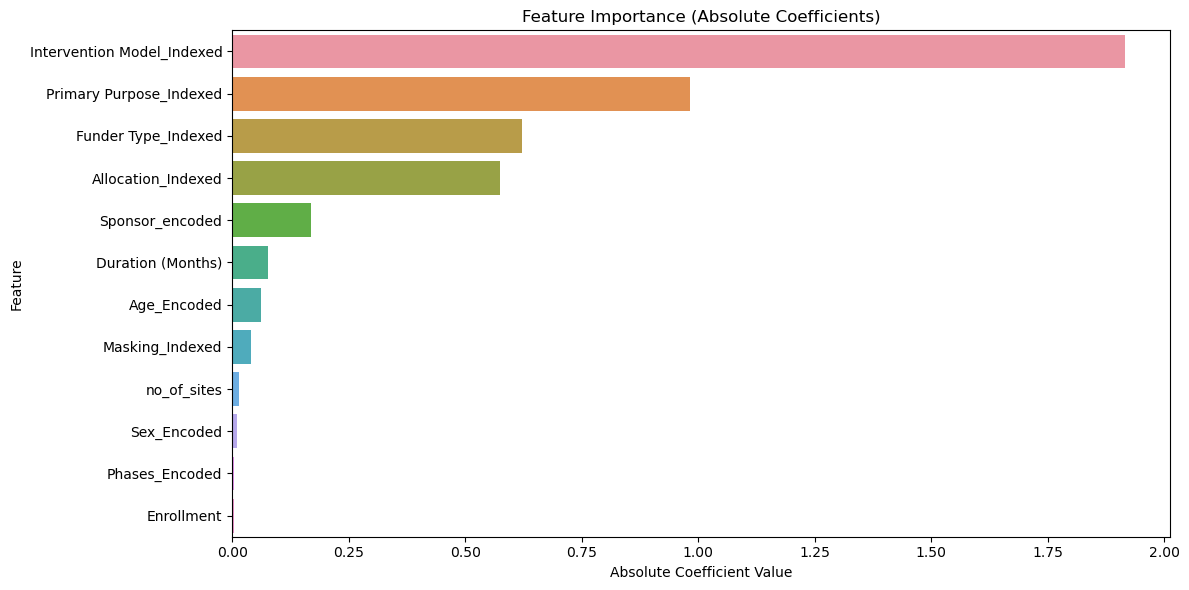

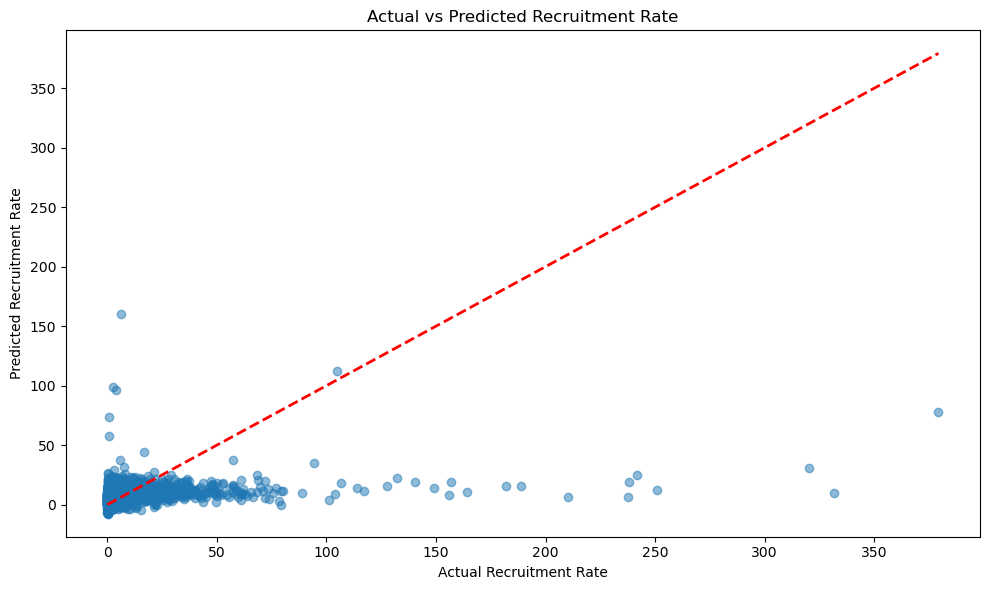


Cross-validation scores: [-1.78438460e-01 -5.11186001e-05  4.18017001e-02 -8.33117427e+00
  2.26482837e-02]
Average CV score: -1.6890 (+/- 6.6440)

Model Coefficients:
                              Feature  Coefficient
0                          Enrollment     0.003391
1                  Allocation_Indexed     0.573747
2          Intervention Model_Indexed    -1.915300
3                     Masking_Indexed     0.040355
4             Primary Purpose_Indexed    -0.982592
5                         Age_Encoded    -0.062333
6                         Sex_Encoded    -0.010649
7                      Phases_Encoded    -0.004553
8                   Duration (Months)    -0.076545
9                         no_of_sites    -0.014696
10                Funder Type_Indexed    -0.621776
11                    Sponsor_encoded     0.169039
intercept                   intercept    23.179536

Example Prediction:
Sample input features:
   Enrollment  Allocation_Indexed  Intervention Model_Indexed  \
0       

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read the dataset
df = pd.read_csv('Final_dataset.csv')

# Select only the relevant numeric columns (excluding embeddings)
feature_columns = [
    'Enrollment', 
    'Allocation_Indexed',
    'Intervention Model_Indexed',
    'Masking_Indexed',
    'Primary Purpose_Indexed',
    'Age_Encoded',
    'Sex_Encoded',
    'Phases_Encoded',
    'Duration (Months)',
    'no_of_sites',
    'Funder Type_Indexed',
    'Sponsor_encoded'
]

# Create feature matrix X and target variable y
X = df[feature_columns]
y = df['Study Recruitment Rate']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the results
print("Model Performance Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': model.coef_
})
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

# Print feature importance
print("\nFeature Importance:")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_importance)
plt.title('Feature Importance (Absolute Coefficients)')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Recruitment Rate')
plt.ylabel('Predicted Recruitment Rate')
plt.title('Actual vs Predicted Recruitment Rate')
plt.tight_layout()
plt.show()

# Add cross-validation
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print("\nCross-validation scores:", cv_scores)
print(f"Average CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Function to make predictions on new data
def predict_recruitment_rate(new_data):
    """
    Make predictions for new data
    new_data should be a DataFrame with the same features as the training data
    """
    return model.predict(new_data)

# Save model coefficients and intercept for future reference
model_coefficients = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': model.coef_
})
model_coefficients.loc['intercept'] = ['intercept', model.intercept_]

print("\nModel Coefficients:")
print(model_coefficients)

# Example of how to use the model for prediction
print("\nExample Prediction:")
sample_input = X.iloc[0:1]  # Take first row as example
print("Sample input features:")
print(sample_input)
prediction = predict_recruitment_rate(sample_input)
print(f"\nPredicted recruitment rate: {prediction[0]:.4f}")